# DTSA-5509 Final Project: Predicting Heart Disease from CDC survey data
## April 24, 2022

## Introduction


In [1]:
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder


In [2]:
df = pd.read_csv("data/heart_2020_cleaned.csv.zip", compression="zip")
print(df.HeartDisease.value_counts(), "\n")
df.info()


No     292422
Yes     27373
Name: HeartDisease, dtype: int64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthm

In [3]:
df.describe()

,BMI,PhysicalHealth,MentalHealth,SleepTime
count,319795.000000,319795.00000,319795.000000,319795.000000
mean,28.325399,3.37171,3.898366,7.097075
std,6.356100,7.95085,7.955235,1.436007
min,12.020000,0.00000,0.000000,1.000000
25%,24.030000,0.00000,0.000000,6.000000
50%,27.340000,0.00000,0.000000,7.000000
75%,31.420000,2.00000,3.000000,8.000000
max,94.850000,30.00000,30.000000,24.000000


In [4]:
def CleanColumn(col):
    if df[col].unique().all() in ['No', 'Yes']:
        df[col] = df[col].map({'Yes':True ,'No':False}).astype(bool)
    else:
        df[col] = df[col].astype("category")
    
for col in df.columns:
    if df[col].dtype == 'object':
        CleanColumn(col)


7.0     97751
8.0     97602
6.0     66721
5.0     19184
9.0     16041
10.0     7796
4.0      7750
12.0     2205
3.0      1992
2.0       788
1.0       551
11.0      415
14.0      243
16.0      236
15.0      189
18.0      102
13.0       97
20.0       64
24.0       30
17.0       21
22.0        9
19.0        3
23.0        3
21.0        2
Name: SleepTime, dtype: int64


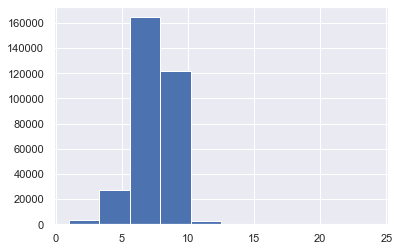

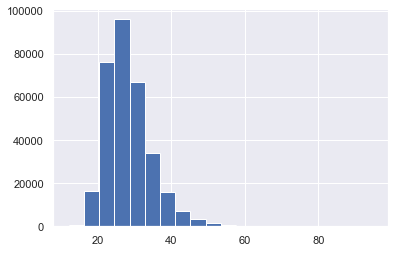

In [5]:
print(df.SleepTime.value_counts())
plt.hist(df.SleepTime)
plt.show()
plt.hist(df.BMI, 20)
plt.show()

In [6]:
print("Before caping:")
print("Count of 19 or more hours Sleep Time: {}".format(len(df[(df.SleepTime >= 19)])))
print("Count of BMI 70 or greater: {}".format(len(df[(df.BMI >= 70)])))

Before caping:
Count of 19 or more hours Sleep Time: 111
Count of BMI 70 or greater: 129


In [7]:
df.SleepTime = df.SleepTime.where(df.SleepTime <= 19, 19)
df.BMI = df.BMI.where(df.BMI <= 70, 70)
#df.SleepTime = df.SleepTime.astype("category")
print("After capping:")
print("Count of Sleep Time exactly 19: {}".format(len(df[(df.SleepTime == 19)])))
print("Count of BMI exactly 70: {}".format(len(df[(df.BMI == 70)])))


After capping:
Count of Sleep Time exactly 19: 111
Count of BMI exactly 70: 129


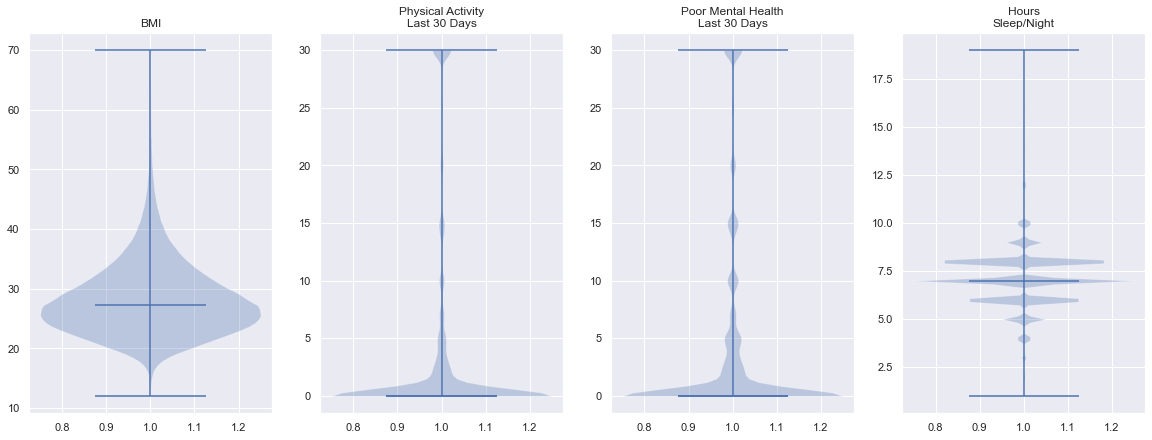

In [8]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows = 1, ncols = 4)

# Plot violin plot on axes 1
ax1.violinplot(df.BMI, showmedians = True)
ax1.set_title('BMI')

# Plot violin plot on axes 2
ax2.violinplot(df.PhysicalHealth, showmedians = True)
ax2.set_title('Physical Activity\nLast 30 Days')

# Plot violin plot on axes 3
ax3.violinplot(df.MentalHealth, showmedians = True)
ax3.set_title('Poor Mental Health\nLast 30 Days')

# Plot violin plot on axes 4
ax4.violinplot(df.SleepTime, showmedians=True)
ax4.set_title('Hours\nSleep/Night')

fig.set_figheight(7)
fig.set_figwidth(20)
plt.show()


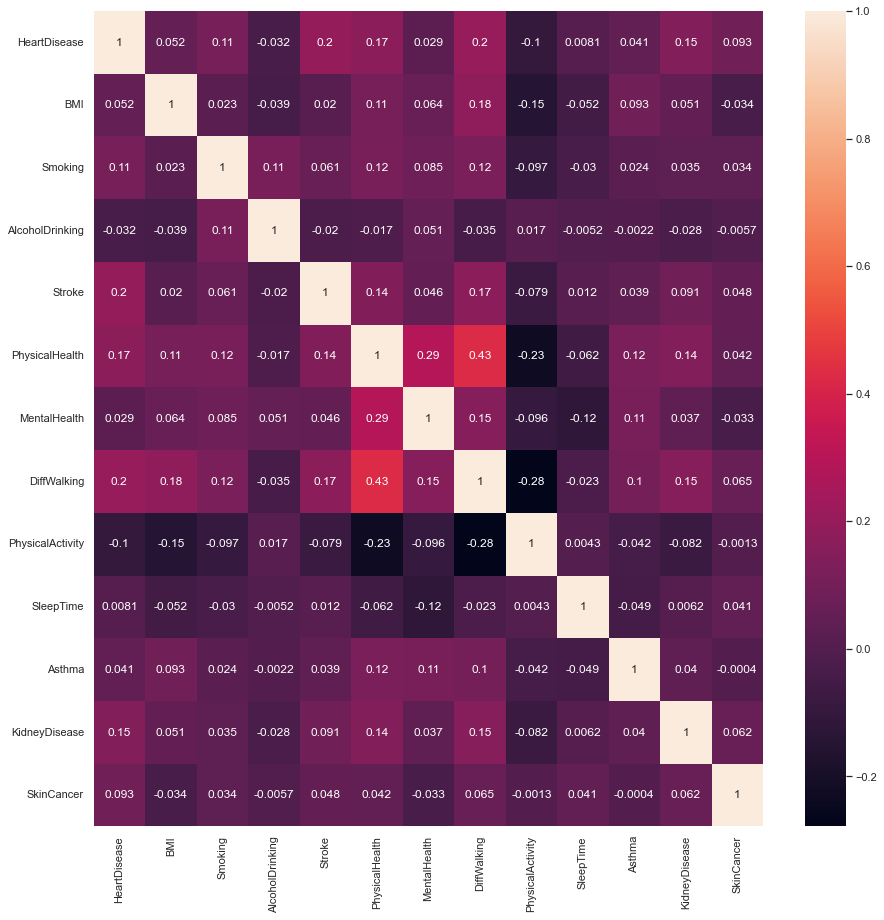

In [9]:
#sns.pairplot(votes, diag_kind = 'kde')
#plt.show()

plt.figure(figsize = (15,15))
sns.heatmap(df.corr(), annot = True)
plt.show()

In [10]:
df = pd.get_dummies(df, columns=['Sex', 'Race'], prefix = ['Gender', 'Race'])
ageDict = {'18-24':1, '25-29':2, '30-34':3, '35-39':4, '40-44':5, '45-49':6, '50-54':7, 
           '55-59':8, '60-64':9, '65-69':10, '70-74':11, '75-79':12, '80 or older':13}
diabeticDict = {'No':1, 'No, borderline diabetes':2, 'Yes (during pregnancy)':3, 'Yes':4}
healthList = {'Poor':1, 'Fair':2, 'Good':3, 'Very good':4, 'Excellent':5}

df['AgeCategory']= df.AgeCategory.map(ageDict)
df['Diabetic']= df.Diabetic.map(diabeticDict)
df['GenHealth']= df.GenHealth.map(healthList)
df.info()

y = df.HeartDisease.values
X = df.drop('HeartDisease', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 24 columns):
 #   Column                               Non-Null Count   Dtype   
---  ------                               --------------   -----   
 0   HeartDisease                         319795 non-null  bool    
 1   BMI                                  319795 non-null  float64 
 2   Smoking                              319795 non-null  bool    
 3   AlcoholDrinking                      319795 non-null  bool    
 4   Stroke                               319795 non-null  bool    
 5   PhysicalHealth                       319795 non-null  float64 
 6   MentalHealth                         319795 non-null  float64 
 7   DiffWalking                          319795 non-null  bool    
 8   AgeCategory                          319795 non-null  category
 9   Diabetic                             319795 non-null  category
 10  PhysicalActivity                     319795 non-null  bool    
 11  

In [11]:
rfModel = RandomForestClassifier().fit(X_train, y_train)
y_pred = rfModel.predict(X_test)


In [12]:
print("Accuracy :{}".format(metrics.accuracy_score(y_test, y_pred)))
print("Precision :{}".format(metrics.precision_score(y_test, y_pred, pos_label = True)))
print("Recall :{}".format(metrics.recall_score(y_test, y_pred, pos_label = True)))
print("F1 score: {}".format(metrics.f1_score(y_test, y_pred)))
print("Area Under Curve: {}".format(metrics.roc_auc_score(y_test, [p[1] for p in rfModel.predict_proba(X_test)])))


Accuracy :0.9048449300218889
Precision :0.35169210351692104
Recall :0.11587232181897683
F1 score: 0.17431343529024831
Area Under Curve: 0.7909967913306066


[[94431  1954]
 [ 8088  1060]]


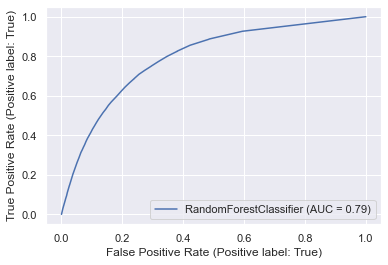

In [22]:
print(metrics.confusion_matrix(y_test, y_pred))
metrics.RocCurveDisplay.from_estimator(rfModel, X_test, y_test)


In [14]:
boostModel = AdaBoostClassifier(n_estimators = 50, random_state = 42).fit(X_train, y_train)
y_pred2 = boostModel.predict(X_test)


In [15]:
print("Accuracy :{}".format(metrics.accuracy_score(y_test, y_pred2)))
print("Precision :{}".format(metrics.precision_score(y_test, y_pred2, pos_label = True)))
print("Recall :{}".format(metrics.recall_score(y_test, y_pred2, pos_label = True)))
print("F1 score: {}".format(metrics.f1_score(y_test, y_pred2)))
print("Area Under ROC: {}".format(metrics.roc_auc_score(y_test, [p[1] for p in boostModel.predict_proba(X_test)])))


Accuracy :0.9140268920621986
Precision :0.5181774115365972
Recall :0.11685614341932662
F1 score: 0.19070555704219072
Area Under ROC: 0.8377070642420484


[[95391   994]
 [ 8079  1069]]


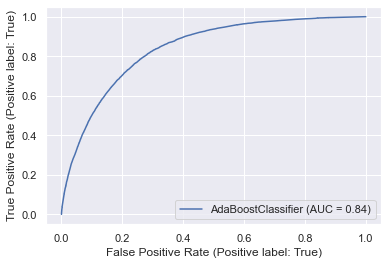

In [23]:
print(metrics.confusion_matrix(y_test, y_pred2))
metrics.RocCurveDisplay.from_estimator(boostModel, X_test, y_test)
